# FashionMNIST Classification with CNN  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Section 1: Data and Data Processing

Importance of Data in Deep Learning - http://deeplizard.com/learn/video/EqpzfvxBx30  
Extract, Transform, Load (ETL) - http://deeplizard.com/learn/video/8n-TGaBZnk4  
PyTorch Datasets and DataLoaders - http://deeplizard.com/learn/video/mUueSPmcOBc  

In [ ]:

learning_rate = 0.075

batch_size =  16

use_gpu = True

num_epochs = 5

In [ ]:

train_set = torchvision.datasets.FashionMNIST(
# train_set = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transforms.Compose([transforms.ToTensor()])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12518863.29it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 214084.29it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3930822.31it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18376405.95it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



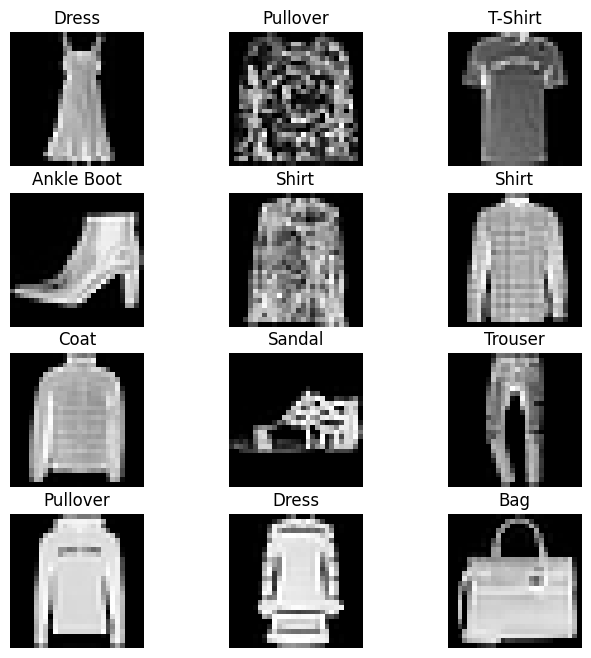

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([16, 1, 28, 28])
Labels batch shape: torch.Size([16])


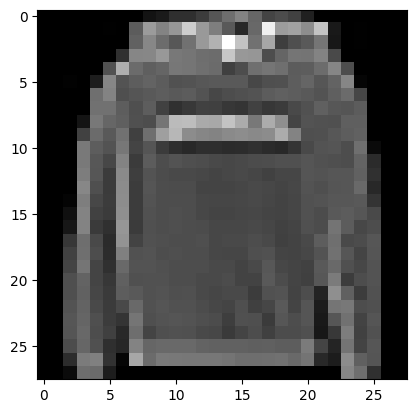

Label: 2


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Section 2: Neural Networks and PyTorch Design

Build PyTorch CNN - http://deeplizard.com/learn/video/k4jY9L8H89U  
CNN Layers - http://deeplizard.com/learn/video/IKOHHItzukk  
CNN Weights - http://deeplizard.com/learn/video/stWU37L91Yc  
Callable Neural Networks - http://deeplizard.com/learn/video/rcc86nXKwkw  
CNN Forward Method - http://deeplizard.com/learn/video/MasG7tZj-hw  

In [ ]:
class Network_FashionMNIST(nn.Module):
    def __init__(self):
        super(Network_FashionMNIST, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128 , kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=128 , out_channels=256, kernel_size=3)       
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
         
  
        self.fc1 = nn.Linear(in_features=12800, out_features=2560)
        self.fc2 = nn.Linear(in_features=2560, out_features=1280)
        self.fc3 = nn.Linear(in_features=1280, out_features=480)
        self.out = nn.Linear(in_features=480, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t       

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)              
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)        
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)        
        t = F.max_pool2d(t, kernel_size=2, stride=2)        
        
        # (5) hidden linear layer        
        t = t.view(t.size(0), -1)
        t = self.fc1(t)
        t = F.relu(t)
        
        # (6) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (7) hidden linear layer
        t = self.fc3(t)
        t = F.relu(t)
        
        # (8) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        
        return t

    # this is a copy of forward used to print the size of the layers
    def print_forward(self, t):
        # (1) input layer
        t = t
        print("(1) input layer: ", t.size())
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)        
        print("(2) hidden conv layer: ", t.size())        
                
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        print("(3) hidden conv layer: ", t.size())        
        
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        print("(3) max pool filter: ", t.size())

        # (4) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)
        print("(4) hidden conv layer: ", t.size())        
        
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        print("(4) max pool filter: ", t.size())
        
        # (5) hidden linear layer
        t = t.view(t.size(0), -1)
        t = self.fc1(t)
        t = F.relu(t)
        print("(5) hidden linear layer: ", t.size())
        
        # (6) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        print("(6) hidden linear layer: ", t.size())

        # (7) hidden linear layer
        t = self.fc3(t)
        t = F.relu(t)
        print("(7) hidden linear layer: ", t.size())
        
        # (8) output layer
        t = self.out(t)
        print("(8) output layer: ", t.size())
        #t = F.softmax(t, dim=1)
        
        return t

# Section 3: Training Neural Networks

In [ ]:
# create instance of the network
network = Network_FashionMNIST()

# print network setup
print(network)

# run the print forward pass to see the sizes of layers
x = torch.randn(1, 1, 28, 28)
network.cpu().print_forward(x);

Network_FashionMNIST(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=2560, bias=True)
  (fc2): Linear(in_features=2560, out_features=1280, bias=True)
  (fc3): Linear(in_features=1280, out_features=480, bias=True)
  (out): Linear(in_features=480, out_features=10, bias=True)
)
(1) input layer:  torch.Size([1, 1, 28, 28])
(2) hidden conv layer:  torch.Size([1, 128, 26, 26])
(3) hidden conv layer:  torch.Size([1, 256, 24, 24])
(3) max pool filter:  torch.Size([1, 256, 12, 12])
(3.5) hidden conv layer:  torch.Size([1, 512, 10, 10])
(3.5) max pool filter:  torch.Size([1, 512, 5, 5])
(4) hidden linear layer:  torch.Size([1, 2560])
(5) hidden linear layer:  torch.Size([1, 1280])
(5.5) hidden linear layer:  torch.Size([1, 480])
(6) output layer:  torch.Size([1, 10])


In [ ]:
# create optimizer, we use the SGD which we learned
optimizer = optim.SGD(network.parameters(), lr=learning_rate) # Optimizer

# creat a device, gpu if requested
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print("used device:", device)

# move the network to the device
network = network.to(device)

# array to store the progress
epoch_loss = []

used device: cuda:0


In [ ]:
# The training loop
for epoch in range(num_epochs):
    t = time.time()
    total_labels = 0  
    total_correct = 0    
    total_loss = 0        
    epoch_loss.append(0)

    for batch in train_loader:
        # get the samples images and their labels for the batk
        images, labels = batch

        # move to selected device (gpu or cpu)
        images = images.to(device)
        labels = labels.to(device)

        # class predictions
        preds = network(images)
        
        # cross-entropy loss
        loss = F.cross_entropy(preds, labels)
        
        # clear gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        # track loss and predicion accuracy
        epoch_loss[-1] += loss.item()
        total_loss += loss.item()
        total_correct += preds.argmax(dim=1).eq(labels).sum().item()
        total_labels += len(labels)

    print('Epoch [%d / %d] loss: %f, accuracy: %f, time: %3.3f' 
          % (epoch+1, num_epochs, total_loss, total_correct/total_labels, np.round_(time.time() - t, 3)))    

Epoch [1 / 5] loss: 2224.207265, accuracy: 0.771933, time: 50.302
Epoch [2 / 5] loss: 1096.903613, accuracy: 0.893067, time: 44.123
Epoch [3 / 5] loss: 853.223013, accuracy: 0.915783, time: 43.885
Epoch [4 / 5] loss: 707.079516, accuracy: 0.930183, time: 43.647
Epoch [5 / 5] loss: 586.615795, accuracy: 0.941567, time: 43.775


Plot Training Curve
--------------------

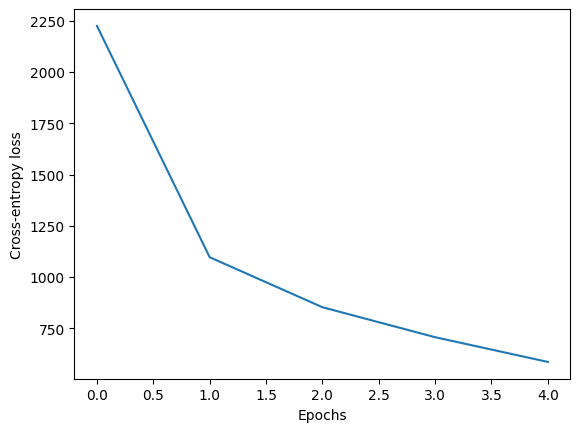

In [ ]:
# plot the loss per epoch curve
fig = plt.figure()
plt.plot(epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

In [ ]:
# Function to get all predictions at once
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        # get the samples images and their labels for the batk
        images, labels = batch

        # move to selected device (gpu or cpu)
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [ ]:
# Analytics
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)

# turn off gradient for forward evaluation
with torch.no_grad():
    train_preds = get_all_preds(network, prediction_loader)
    preds_correct = train_preds.argmax(dim=1).eq(train_set.targets.to(device)).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 57507
accuracy: 0.95845


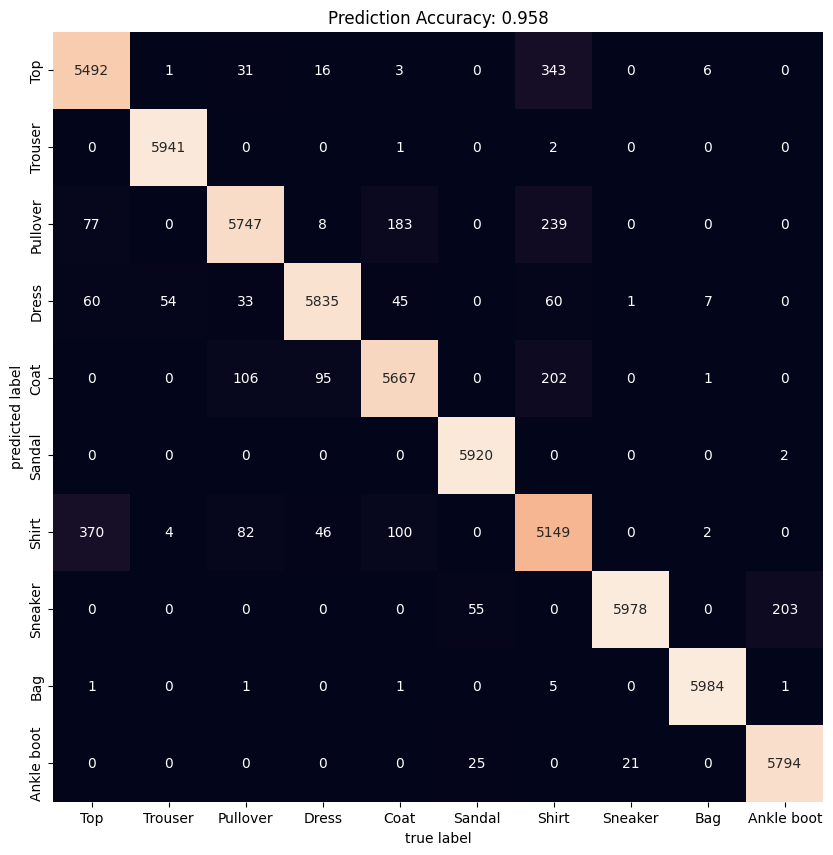

In [ ]:
# move data to cpu for using scikit 
targets_cpu = train_set.targets.cpu()
preds_cpu = train_preds.cpu()

# compute the confusion matrix
cm = confusion_matrix(targets_cpu, preds_cpu.argmax(dim=1))
labels_names = ('Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')

# plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(targets_cpu, preds_cpu.argmax(dim=1)));

---
## Results & Conclusions  
- Final accuracy: ~95.8% in 5 epochs  
- GPU vs CPU runtime: ~44× speedup  
- Future: experiment with data augmentation and deeper layers.